In [1]:
from extractor import *

from algo_spam import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import os.path
from os import path

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package wordnet to /home/fabian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fabian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing the datasets

In [10]:
link_datafolder = "./../../../checkdatasets/"

dataset = import_email_data(link_folder=link_datafolder)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Description of raw data

In [11]:
# check how many emails we have in the dataset
n_mails = len(dataset)
n_spam  = np.sum(dataset['Label']==1)
n_ham   = n_mails-n_spam
print("The dataset contains {} emails in total. {:.4}% are spam and {:.4}% are non-spam emails.".format(n_mails,
                                                                                               n_spam/n_mails*100, 
                                                                                                n_ham/n_mails*100))

The dataset contains 12604 emails in total. 43.11% are spam and 56.89% are non-spam emails.


The maximum number or chars in a email is 17085626.
The minimum number or chars in a email is 10.


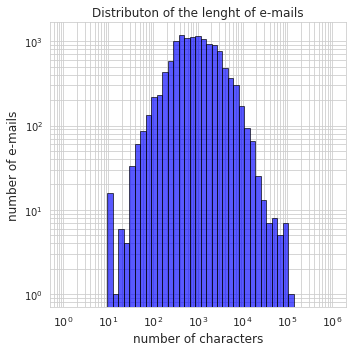

In [4]:
textlen = [len(text) for text in dataset["Body"]]
plt.figure(figsize=(5,5))
plt.hist(textlen, bins=np.logspace(np.log10(1),np.log10(1e6), 50), color='blue', edgecolor='k', alpha=0.65)
plt.xticks(fontsize=11)
plt.title("Distributon of the lenght of e-mails",fontsize=12)
plt.ylabel("number of e-mails",fontsize=12)
plt.xlabel("number of characters",fontsize=12)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.savefig("./char_count.pdf")
print("The maximum number or chars in a email is {}.".format(np.max(textlen))  )
print("The minimum number or chars in a email is {}.".format(np.min(textlen))  )

In [12]:
remove_duplicates(dataset["Body"], remove_dups=False, print_dups=True)
remove_missing_vals(dataset["Body"], remove_missing=False, print_missing=True)

There are 327 duplicates.
There are:
 0 
 missing values.


# Clean up datasets

In [13]:
train_set = remove_duplicates(train_set, remove_dups=True, print_dups=True)
train_set = remove_missing_vals(train_set, remove_missing=True, print_missing=True)

There are 213 duplicates.
There are:
 Body     0
Label    0
dtype: int64 
 missing values.


In [14]:
# try to reload datasets with extracted features to save up time
force_repickle = False # force to extract features again
pickle_name    = "datasets_optimum_clean"

if path.exists(link_datafolder+pickle_name) and (not force_repickle):
    print("realoading cleaned dataset\n")
    [train_set_clean, 
     test_set_clean] = pickle_data(link_folder=link_datafolder, 
                                    name=pickle_name, operation="rb")
else:
    print("pickling cleaned dataset\n")
    train_set_clean = prep_mails(train_set['Body'])
    test_set_clean = prep_mails(test_set['Body'])
    pickle_data(data_item=[train_set_clean, 
                           test_set_clean], link_folder=link_datafolder, 
                name=pickle_name, operation="wb")

realoading cleaned dataset



# extract features

In [15]:
train_set_copy = train_set # make a copy before we remove outlyers

In [8]:
vectorizer_bow ,train_vec, test_vec =\
create_vectorizer(train_set_clean, test_set_clean, max_features=500)

[train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=99999)

removing 0 rows



# check for outlyers and value range

In [10]:
# extract vectors with 8k lenght
vectorizer_bow ,train_vec, test_vec =\
create_vectorizer(train_set_clean, test_set_clean, max_features=8000)
# allow unbounded values for vectors
[train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=99999)

removing 0 rows



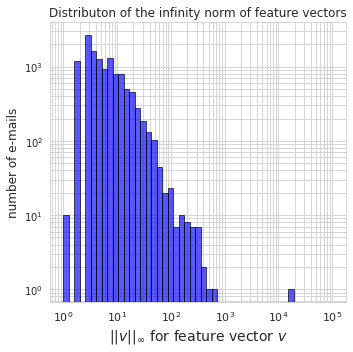

In [11]:

plt.figure(figsize=(5,5))
plt.hist(np.max(np.concatenate((train_vec,test_vec),axis=0)+1,axis=1), 
         bins=np.logspace(np.log10(1),np.log10(1e5), 50), color='blue', edgecolor='k', alpha=0.65)
plt.xticks(fontsize=11)
plt.title("Distributon of the infinity norm of feature vectors",fontsize=12)
plt.ylabel("number of e-mails",fontsize=12)
plt.xlabel(r"$||v||_\infty$ for feature vector $v$",fontsize=14)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.savefig("./word_count.pdf")

In [ ]:
# extract vectors with 8k lenght
vectorizer_bow ,train_vec, test_vec =\
create_vectorizer(train_set_clean, test_set_clean, max_features=8000)
# remove vecors with <1k entries
[train_vec, train_set] = remove_outlyers(train_vec, train_set_copy, threshold=1e3)
# transform to logarithmic range
[train_vec, test_vec] = get_log_range(train_vec, test_vec)

removing 1 rows



In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.max(np.concatenate((train_vec,test_vec),axis=0),axis=1), 
         bins=np.linspace(0,3, 50), color='blue', edgecolor='k', alpha=0.65)
plt.xticks(fontsize=11)
plt.title("Distributon of the infinity norm of \n transformed feature vectors",fontsize=12)
plt.ylabel("number of e-mails",fontsize=12)
plt.xlabel(r"$||\log_{10}(v+1)||_\infty$ for feature vector $v$",fontsize=14)
plt.gca().set_yscale("log")
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.savefig("./word_transformed_count.pdf")

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# define function that does the extractionsteps
def extract_and_prep(train_set_clean, test_set_clean, df_train_set, max_features=1, threshold=1e10, skaler=0):
    # extract vectors with 8k lenght
    vectorizer_bow ,train_vec, test_vec =\
    create_vectorizer(train_set_clean, test_set_clean, max_features = max_features)
    # remove vecors with <1k entries
    [train_vec, train_set] = remove_outlyers(train_vec, df_train_set, threshold = threshold)
    # choose a skaler
    if skaler==3:
        scaler = MinMaxScaler()
    elif skaler==4:
        scaler = StandardScaler()
    elif skaler==5:
        scaler = Normalizer()
        
    if skaler==1:
        # transform to logarithmic range
        [train_vec, test_vec] = get_log_range(train_vec, test_vec)
    elif skaler==2:
        # transform to binary range
        train_vec[train_vec>0] = 1
        test_vec[test_vec>0] =1
    elif skaler!=0:
        scaler.fit(train_vec)
        train_vec = scaler.transform(train_vec)
        scaler.fit(test_vec)
        test_vec = scaler.transform(test_vec)
    train_vec, vali_vec, train_set, vali_set = train_test_split(train_vec, train_set, 
                                                                test_size=0.2, random_state=42)
    return train_vec, test_vec, vali_vec, train_set, vali_set

In [8]:
from sklearn.metrics import f1_score

# Perceptron

skaler 0 evaluation
removing 1 rows

skaler 1 evaluation
removing 1 rows

skaler 2 evaluation
removing 1 rows

skaler 3 evaluation
removing 1 rows

skaler 4 evaluation
removing 1 rows

skaler 5 evaluation
removing 1 rows



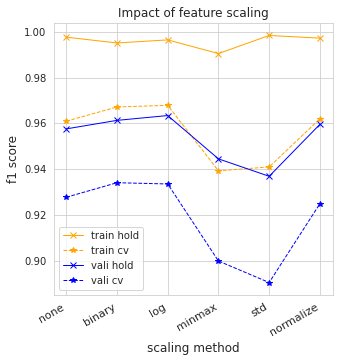

In [25]:
# extract for now only 3000 words with threshold 1000
# check impact of feature scaling
vals      = np.arange(6)
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print("skaler {} evaluation".format(x))
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=3000, threshold=1e3,skaler=x)
    ppn = create_perceptron(train_vec, train_set['Label'])
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())

plt.figure(figsize=(5,5))
plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
plt.legend(loc="best")
plt.title("Impact of feature scaling",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("scaling method",fontsize=12)
labels =["none", "binary", "log", "minmax", "std", "normalize"]
plt.xticks(vals, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./perc_scaling.pdf")

removing 1 rows

removing 1 rows

removing 1 rows

removing 1 rows

removing 1 rows

removing 1 rows

removing 1 rows



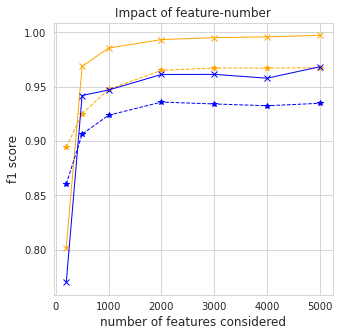

In [28]:
# check for performance with different feature numbers
vals      = [200, 500, 1000, 2000, 3000, 4000, 5000]
scores    = [[],[]]
scores_cv = [[],[]]

for x in vals:
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=x, threshold=1e3,skaler=1)
    ppn = create_perceptron(train_vec, train_set['Label'])
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
    
plt.figure(figsize=(5,5))
plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of feature-number",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("number of features considered",fontsize=12)
plt.savefig("./perc_features.pdf")

In [29]:
train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=3000, threshold=1e3,skaler=1)

removing 1 rows



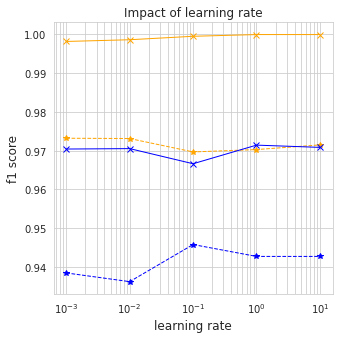

In [23]:
# learning rate
vals      = np.array([1e-3, 1e-2, 1e-1, 1e-0, 10])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=x)
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
plt.figure(figsize=(5,5))
plt.semilogx(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.semilogx(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.semilogx(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.semilogx(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.grid(True, which="both", ls="-")
plt.title("Impact of learning rate",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("learning rate",fontsize=12)
plt.savefig("./perc_learning_rate.pdf")

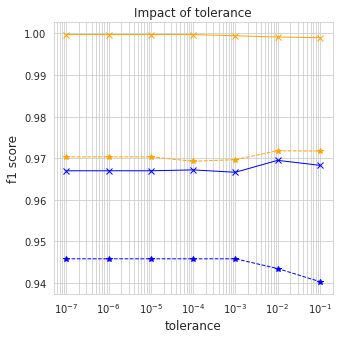

In [30]:
# stopping criterion
import warnings
warnings.filterwarnings('ignore')
vals      = np.array([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=1e-1, tol =x, max_iter=1e5)
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
plt.figure(figsize=(5,5))
plt.semilogx(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.semilogx(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.semilogx(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.semilogx(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.grid(True, which="both", ls="-")
plt.title("Impact of tolerance",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("tolerance",fontsize=12)
plt.savefig("./perc_tolerance.pdf")

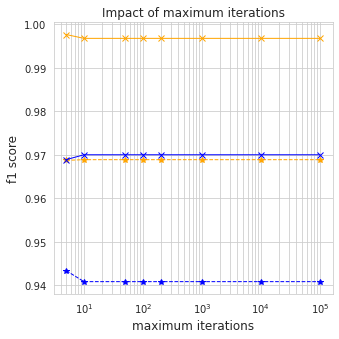

In [27]:
# maximum iterations
import warnings
warnings.filterwarnings('ignore')
vals      = np.array([5, 10, 50, 100, 200, 1000, 1e4,1e5])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=1e-7, max_iter=x)
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
plt.figure(figsize=(5,5))
plt.semilogx(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.semilogx(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.semilogx(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.semilogx(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.grid(True, which="both", ls="-")
plt.title("Impact of maximum iterations",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("maximum iterations",fontsize=12)
plt.savefig("./perc_maxiter.pdf")

Text(0.5, 0, 'penalty method')

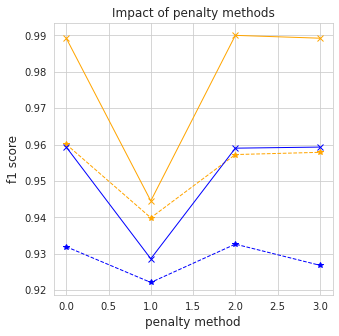

In [33]:
# penalty parameter
vals_names = ["l2","l1","elasticnet","None"]
vals       = [0, 1, 2, 3]
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals_names:
    ppn = create_perceptron(train_vec, train_set['Label'], eta0=1e-7, max_iter=20, penalty=x)
    scores[0].append( f1_score( ppn.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( ppn.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(ppn, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(ppn, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
plt.figure(figsize=(5,5))
plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of penalty methods",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("penalty method",fontsize=12)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
param_grid = {'eta0':[1e-5,1e-4,1e-3,1e-2], 
              'tol':[1e-9,1e-6, 1e-5, 1e-4],
             'max_iter':[5, 10, 50,],
             #'penalty':("l2","l1","elasticnet","None"),
             #'alpha':[1e-4,1e-3,1e-2,1e-1]
             }
ppn = create_perceptron(train_vec, train_set['Label'], eta0=1e-7, max_iter=20, penalty=None)
grid = GridSearchCV(ppn, param_grid, refit = True, verbose = 3,n_jobs=-1, scoring='f1')
grid.fit(vali_vec, vali_set['Label'])
print(grid.best_params_)
grid_predictions = grid.predict(vali_vec) 
print(classification_report(vali_set['Label'], grid_predictions)) 
grid_predictions = grid.predict(test_vec) 
print(classification_report(test_set['Label'], grid_predictions)) 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'eta0': 0.0001, 'max_iter': 10, 'tol': 1e-06}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1186
           1       1.00      0.98      0.99       788

    accuracy                           0.99      1974
   macro avg       0.99      0.99      0.99      1974
weighted avg       0.99      0.99      0.99      1974

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1416
           1       0.97      0.94      0.95      1105

    accuracy                           0.96      2521
   macro avg       0.96      0.96      0.96      2521
weighted avg       0.96      0.96      0.96      2521



# compare CV and holdout

In [31]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
ppn = create_perceptron(train_vec, train_set['Label'], eta0=1e-3, max_iter=10, tol=1e-6,)
# percision: Of the spam filter says this email is spam, what’s the probability that it’s spam?
# recall: Of all the spam in the email set, what fraction did the spam filter detect?”
scores_test_cv = cross_validate(ppn, test_vec, test_set['Label'], scoring='f1', cv=10)
scores_test_hold =f1_score( ppn.predict(test_vec), test_set['Label'])
print("CV testset f1 score: {:.4}\nholdout testset f1 score: {:.4}".format(scores_test_cv['test_score'].mean(), 
                                                                     scores_test_hold))

CV testset f1 score: 0.9517
holdout testset f1 score: 0.9683


# Random Forrest

skaler 0 evaluation
removing 1 rows

skaler 1 evaluation
removing 1 rows

skaler 2 evaluation
removing 1 rows

skaler 3 evaluation
removing 1 rows

skaler 4 evaluation
removing 1 rows

skaler 5 evaluation
removing 1 rows



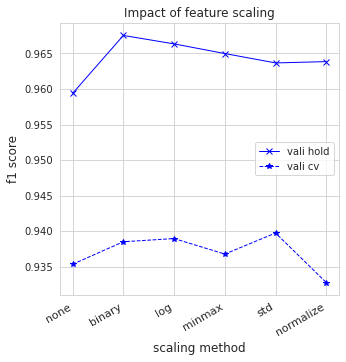

In [77]:
# extract for now only 3000 words with threshold 1000
# check impact of feature scaling
vals      = np.arange(6)
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print("skaler {} evaluation".format(x))
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=8000, threshold=1e3,skaler=x)
    clf = create_rnd_forrest(train_vec, train_set['Label'],n_estimators=50)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())

plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
plt.legend(loc="best")
plt.title("Impact of feature scaling",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("scaling method",fontsize=12)
labels =["none", "binary", "log", "minmax", "std", "normalize"]
plt.xticks(vals, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./rnd_scaling.pdf")

200
removing 1 rows

500
removing 1 rows

1000
removing 1 rows

2000
removing 1 rows

3000
removing 1 rows

4000
removing 1 rows

5000
removing 1 rows

6000
removing 1 rows

7000
removing 1 rows

8000
removing 1 rows

9000
removing 1 rows

10000
removing 1 rows



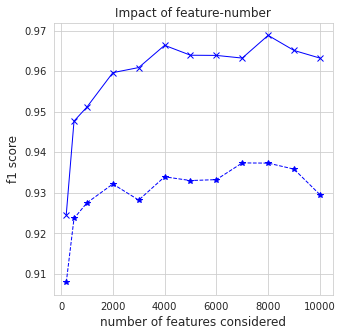

In [76]:
# check for performance with different feature numbers
vals      = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
scores    = [[],[]]
scores_cv = [[],[]]

for x in vals:
    print(x)
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=x, threshold=1e3,skaler=0)
    clf = create_rnd_forrest(train_vec, train_set['Label'],n_estimators=50)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
    
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of feature-number",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("number of features considered",fontsize=12)
plt.savefig("./rnd_features.pdf")

In [32]:
train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=7000, threshold=1e3,skaler=0)

removing 1 rows



1
5
10
50
70


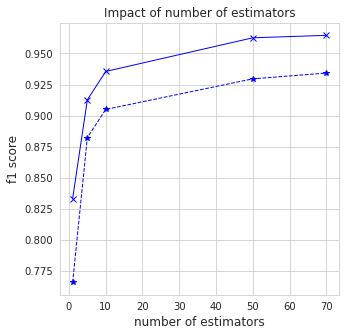

In [14]:
# trees in the forrest
vals      = np.array([1,5,10,50,70])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42, n_estimators=x)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of number of estimators",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("number of estimators",fontsize=12)
plt.savefig("./rnd_trees.pdf")

1e-05
0.0001
0.0002
0.0003
0.0005
0.001
0.005


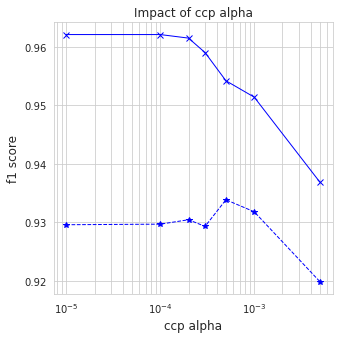

In [35]:
# cost complexity pruning
vals      = np.array([1e-5,1e-4, 2e-4, 3e-4, 5e-4, 1e-3, 5e-3])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42, n_estimators=50, ccp_alpha=x)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.semilogx(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.semilogx(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.grid(True, which="both", ls="-")
plt.title("Impact of ccp alpha",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("ccp alpha",fontsize=12)
plt.savefig("./rnd_ccpalpha.pdf")

10
40
50
60
80


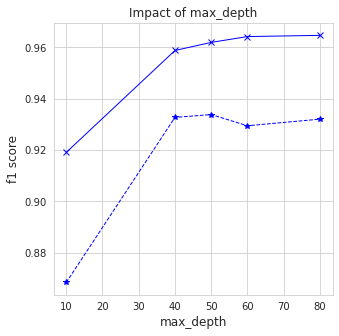

In [88]:
# max depth
vals      = np.array([10,40,50,60, 80])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42, n_estimators=50, max_depth=x)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of max_depth",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("max_depth",fontsize=12)
plt.savefig("./rnd_depth.pdf")

2
5
10
15
20


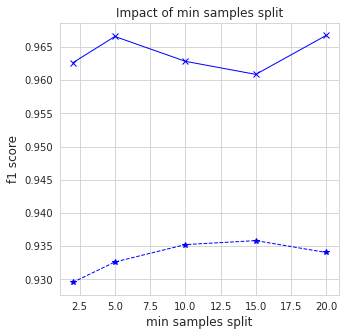

In [36]:
# min_samples_split
vals      = np.array([2, 5, 10, 15, 20])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42, n_estimators=50, min_samples_split=x)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of min samples split",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("min samples split",fontsize=12)
plt.savefig("./rnd_min_samples_split.pdf")

2
5
10
15
20


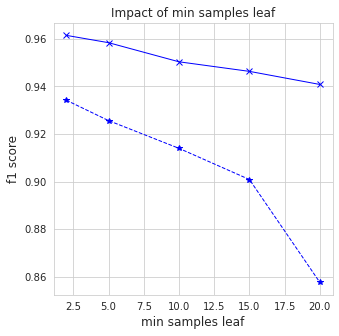

In [38]:
# min_samples_leaf
vals      = np.array([2, 5, 10, 15, 20])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42, n_estimators=50,
                            min_samples_leaf=x)
    #scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    #scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
#plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
#plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of min samples leaf",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("min samples leaf",fontsize=12)
plt.savefig("./rnd_min_samples_leaf.pdf")

In [26]:
param_grid = {'max_depth':[40,50,60,70], 
              'n_estimators':[20,50,70],
             'ccp_alpha':[1e-4, 2e-4, 3e-4, 5e-4],
             #'penalty':("l2","l1","elasticnet","None"),
             #'alpha':[1e-4,1e-3,1e-2,1e-1]
             }
clf = create_rnd_forrest(train_vec, train_set['Label'], random_state=42)
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3,n_jobs=-1, scoring='f1')
grid.fit(vali_vec, vali_set['Label'])
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(vali_vec) 
print(classification_report(vali_set['Label'], grid_predictions)) 
grid_predictions = grid.predict(test_vec) 
print(classification_report(test_set['Label'], grid_predictions)) 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'ccp_alpha': 0.0005, 'max_depth': 60, 'n_estimators': 70}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1186
           1       0.98      1.00      0.99       788

    accuracy                           0.99      1974
   macro avg       0.99      0.99      0.99      1974
weighted avg       0.99      0.99      0.99      1974

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1416
           1       0.94      0.97      0.95      1105

    accuracy                           0.96      2521
   macro avg       0.96      0.96      0.96      2521
weighted avg       0.96      0.96      0.96      2521



# compare CV and holdout

In [28]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
clf = create_rnd_forrest(train_vec, train_set['Label'], ccp_alpha=5e-3, max_depth=60, n_estimators=70)
# percision: Of the spam filter says this email is spam, what’s the probability that it’s spam?
# recall: Of all the spam in the email set, what fraction did the spam filter detect?”
scores_test_cv = cross_validate(clf, test_vec, test_set['Label'], scoring='f1', cv=5)
scores_test_hold =f1_score( clf.predict(test_vec), test_set['Label'])
print("CV testset f1 score: {:.2}\nholdout testset f1 score: {:.2}".format(scores_test_cv['test_score'].mean(), 
                                                                     scores_test_hold))

CV testset f1 score: 0.93
holdout testset f1 score: 0.93


# Naive Bayes

200
removing 1 rows

500
removing 1 rows

1000
removing 1 rows

2000
removing 1 rows

3000
removing 1 rows

4000
removing 1 rows

5000
removing 1 rows

6000
removing 1 rows

7000
removing 1 rows

8000
removing 1 rows

9000
removing 1 rows

10000
removing 1 rows



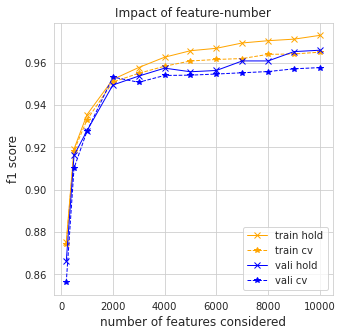

In [30]:
# check for performance with different feature numbers
vals      = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
scores    = [[],[]]
scores_cv = [[],[]]

for x in vals:
    print(x)
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=x, threshold=1e3,skaler=0)
    clf = create_nb(train_vec, train_set['Label'])
    scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())
    
plt.figure(figsize=(5,5))
plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
plt.legend(loc="best")
plt.title("Impact of feature-number",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("number of features considered",fontsize=12)
plt.savefig("./nb_features.pdf")

skaler 0 evaluation
removing 1 rows

skaler 1 evaluation
removing 1 rows

skaler 2 evaluation
removing 1 rows

skaler 3 evaluation
removing 1 rows



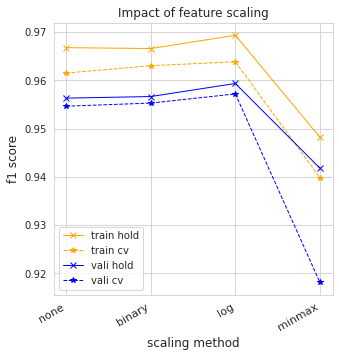

In [18]:
# extract for now only 3000 words with threshold 1000
# check impact of feature scaling
vals      = np.arange(4)
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print("skaler {} evaluation".format(x))
    train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=6000, threshold=1e3,skaler=x)
    clf = create_nb(train_vec, train_set['Label'])
    scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=10).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=10).mean())

plt.figure(figsize=(5,5))
plt.plot(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.plot(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.plot(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.plot(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
plt.legend(loc="best")
plt.title("Impact of feature scaling",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("scaling method",fontsize=12)
labels =["none", "binary", "log", "minmax"]
plt.xticks(vals, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./nb_scaling.pdf")

In [39]:
train_vec, test_vec, vali_vec, train_set, vali_set =extract_and_prep(train_set_clean, 
                                                                     test_set_clean, train_set_copy,
                                                                     max_features=6000, threshold=1e3,skaler=2)

removing 1 rows



0.01
0.1
0.5
1.0
10.0


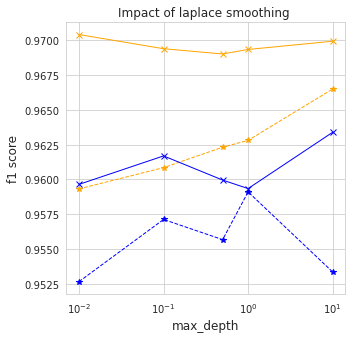

In [41]:
# laplace smoothing parameter
vals      = np.array([1e-2, 1e-1, 0.5, 1, 10])
scores    = [[],[]]
scores_cv = [[],[]]
for x in vals:
    print(x)
    clf = create_nb(train_vec, train_set['Label'], alpha=x)
    scores[0].append( f1_score( clf.predict(train_vec), train_set['Label']) )
    scores[1].append( f1_score( clf.predict(vali_vec), vali_set['Label']) )
    scores_cv[0].append(cross_val_score(clf, train_vec, train_set['Label'], scoring="f1", cv=4).mean())
    scores_cv[1].append(cross_val_score(clf, vali_vec, vali_set['Label'], scoring="f1", cv=4).mean())
plt.figure(figsize=(5,5))
plt.semilogx(vals, scores[0],color="orange",marker="x", linewidth=1,label="train hold")
plt.semilogx(vals, scores_cv[0],"--",color="orange",marker="*", linewidth=1,label="train cv")
plt.semilogx(vals, scores[1],color="blue",marker="x", linewidth=1,label="vali hold")
plt.semilogx(vals, scores_cv[1],"--",color="blue",marker="*", linewidth=1,label="vali cv")
#plt.legend(loc="best")
plt.title("Impact of laplace smoothing ",fontsize=12)
plt.ylabel("f1 score",fontsize=12)
plt.xlabel("max_depth",fontsize=12)
plt.savefig("./nb_smoother.pdf")

# compare CV and holdout

In [22]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
clf = create_nb(train_vec, train_set['Label'])
# percision: Of the spam filter says this email is spam, what’s the probability that it’s spam?
# recall: Of all the spam in the email set, what fraction did the spam filter detect?”
scores_test_cv = cross_validate(clf, test_vec, test_set['Label'], scoring='f1', cv=10)
scores_test_hold =f1_score( clf.predict(test_vec), test_set['Label'])
print("CV testset f1 score: {:.2}\nholdout testset f1 score: {:.2}".format(scores_test_cv['test_score'].mean(), 
                                                                     scores_test_hold))

CV testset f1 score: 0.96
holdout testset f1 score: 0.97
